# Machine Learning Pipeline - Model Training

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline.

We will discuss:

1. Data Analysis
2. Feature Engineering
3. Feature Selection
4. **Model Training**
5. Obtaining Predictions / Scoring

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# to save the model
import joblib

# algorithms to build and train the models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# to evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# to scale the features
from sklearn.preprocessing import MinMaxScaler

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load the train and test set with the engineered variables
X_train = pd.read_csv('xtrain_unscaled.csv')
X_test = pd.read_csv('xtest_unscaled.csv')

In [3]:
y_train = pd.read_csv('ytrain.csv')
y_test = pd.read_csv('ytest.csv')

In [4]:
# load the pre-selected features
features = pd.read_csv('selected_features.csv')
features = features['0'].to_list()

# display the final feature set
features 

['Age',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ST_Slope',
 'Sex_M',
 'ExerciseAngina_Y',
 'FastingBS_1']

In [5]:
# reduce the train and test set to the selected features
X_train = X_train[features]
X_test = X_test[features]

In [6]:
X_train.columns

Index(['Age', 'ChestPainType', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
       'ST_Slope', 'Sex_M', 'ExerciseAngina_Y', 'FastingBS_1'],
      dtype='object')

# Feature Scaling

We have to scale our features because a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the original unit of the values. 

Since scaling is typically done to limit value between 0 and 1, we will exclude our binary features and focus on non-binary/discrete and continuous features. 

Let's grab the features that have more than 2 unique values:

In [7]:
for var in X_train.columns:
    print(f'{var}: {X_train[var].nunique()}')

Age: 49
ChestPainType: 4
RestingBP: 63
Cholesterol: 205
MaxHR: 115
Oldpeak: 48
ST_Slope: 3
Sex_M: 2
ExerciseAngina_Y: 2
FastingBS_1: 2


In [8]:
# list out all the continuous variables that will be scaled
scaled = [feat for feat in X_train.columns if X_train[feat].nunique() > 2]
scaled

['Age',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ST_Slope']

Let's observe the initial range of our continuous variables before the scaling operation. Notice that seem to fall in different ranges.

In [9]:
X_train[scaled].describe()

,Age,ChestPainType,RestingBP,Cholesterol,MaxHR,Oldpeak,ST_Slope
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.633515,2.916894,132.724420,242.881864,136.682561,0.894959,2.062670
std,9.339761,1.240478,17.808146,52.977081,25.633928,1.047775,0.962544
min,28.000000,1.000000,80.000000,85.000000,63.000000,-2.600000,1.000000
25%,47.250000,2.000000,120.000000,213.000000,120.000000,0.000000,1.000000
50%,54.000000,4.000000,130.000000,242.881864,138.000000,0.600000,2.000000
75%,60.000000,4.000000,140.000000,265.000000,156.000000,1.500000,3.000000
max,77.000000,4.000000,200.000000,603.000000,202.000000,6.200000,3.000000


In [10]:
# load the scaler object
scaler = MinMaxScaler()

# fit the train set
scaler.fit(X_train[scaled])

# transform the train and test set
X_train[scaled] = scaler.transform(X_train[scaled])
X_test[scaled] = scaler.transform(X_test[scaled])

In [11]:
# display the scaled dataset
X_train[scaled].head()

,Age,ChestPainType,RestingBP,Cholesterol,MaxHR,Oldpeak,ST_Slope
0,0.857143,1.000000,0.500000,0.304791,0.676259,0.522727,1.0
1,0.367347,1.000000,0.291667,0.304791,0.359712,0.465909,1.0
2,0.755102,0.333333,0.666667,0.530888,0.633094,0.386364,0.0
3,0.775510,1.000000,0.500000,0.104247,0.223022,0.409091,1.0
4,0.632653,1.000000,0.500000,0.304791,0.388489,0.409091,1.0


In [12]:
X_train[scaled].describe().round(2)

,Age,ChestPainType,RestingBP,Cholesterol,MaxHR,Oldpeak,ST_Slope
count,734.00,734.00,734.00,734.00,734.00,734.00,734.00
mean,0.52,0.64,0.44,0.30,0.53,0.40,0.53
std,0.19,0.41,0.15,0.10,0.18,0.12,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.39,0.33,0.33,0.25,0.41,0.30,0.00
50%,0.53,1.00,0.42,0.30,0.54,0.36,0.50
75%,0.65,1.00,0.50,0.35,0.67,0.47,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Notice how all the values of the continuous variables now fall between 0 and 1.

# Model Training

To train the model, we will be trying the following learning approaches:

- Logistic Regression
- Decision Trees
- Random Forests
- Nearest Neighbors
- Support Vector Machines

Our metric of priority will be the f-1 score for the 'Y' label, i.e. the 1 class. Since both target labels are fairly balanced, we can also observe the accuracy score for the model.

## Logistic Regression

In [13]:
f1_scores = {}
accuracy_scores = {}

In [14]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train['HeartDisease'])
log_preds = log_model.predict(X_test)

f1_scores['log_model'] = f1_score(y_test,log_preds)
accuracy_scores['log_model'] = accuracy_score(y_test,log_preds)

print(confusion_matrix(y_test,log_preds))
print()
print(classification_report(y_test,log_preds))

[[56 21]
 [12 95]]

              precision    recall  f1-score   support

           0       0.82      0.73      0.77        77
           1       0.82      0.89      0.85       107

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184



## Decision Tree

In [15]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train,y_train['HeartDisease'])
tree_preds = tree_model.predict(X_test)

f1_scores['tree_model'] = f1_score(y_test,tree_preds)
accuracy_scores['tree_model'] = accuracy_score(y_test,tree_preds)

print(confusion_matrix(y_test,tree_preds))
print()
print(classification_report(y_test,tree_preds))

[[61 16]
 [23 84]]

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        77
           1       0.84      0.79      0.81       107

    accuracy                           0.79       184
   macro avg       0.78      0.79      0.78       184
weighted avg       0.79      0.79      0.79       184



## Random Forests

In [16]:
forest_model = RandomForestClassifier(n_estimators=200,random_state=0)
forest_model.fit(X_train,y_train['HeartDisease'])
forest_preds = forest_model.predict(X_test)

f1_scores['forest_model'] = f1_score(y_test,forest_preds)
accuracy_scores['forest_model'] = accuracy_score(y_test,forest_preds)

print(confusion_matrix(y_test,forest_preds))
print()
print(classification_report(y_test,forest_preds))

[[60 17]
 [11 96]]

              precision    recall  f1-score   support

           0       0.85      0.78      0.81        77
           1       0.85      0.90      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



## Nearest Neighbors

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train,y_train['HeartDisease'])
knn_preds = knn_model.predict(X_test)

f1_scores['knn_model'] = f1_score(y_test,knn_preds)
accuracy_scores['knn_model'] = accuracy_score(y_test,knn_preds)

print(confusion_matrix(y_test,knn_preds))
print()
print(classification_report(y_test,knn_preds))

[[62 15]
 [12 95]]

              precision    recall  f1-score   support

           0       0.84      0.81      0.82        77
           1       0.86      0.89      0.88       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



## Support Vector Machines

In [18]:
svc_model = SVC()
svc_model.fit(X_train,y_train['HeartDisease'])
svc_preds = svc_model.predict(X_test)

f1_scores['svc_model'] = f1_score(y_test,svc_preds)
accuracy_scores['svc_model'] = accuracy_score(y_test,svc_preds)

print(confusion_matrix(y_test,svc_preds))
print()
print(classification_report(y_test,svc_preds))

[[57 20]
 [11 96]]

              precision    recall  f1-score   support

           0       0.84      0.74      0.79        77
           1       0.83      0.90      0.86       107

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



# Model Evaluation

Let's plot out the f1 scores and the accuracy scores from all our models:

Text(0.5, 1.0, 'Model Evaluation')

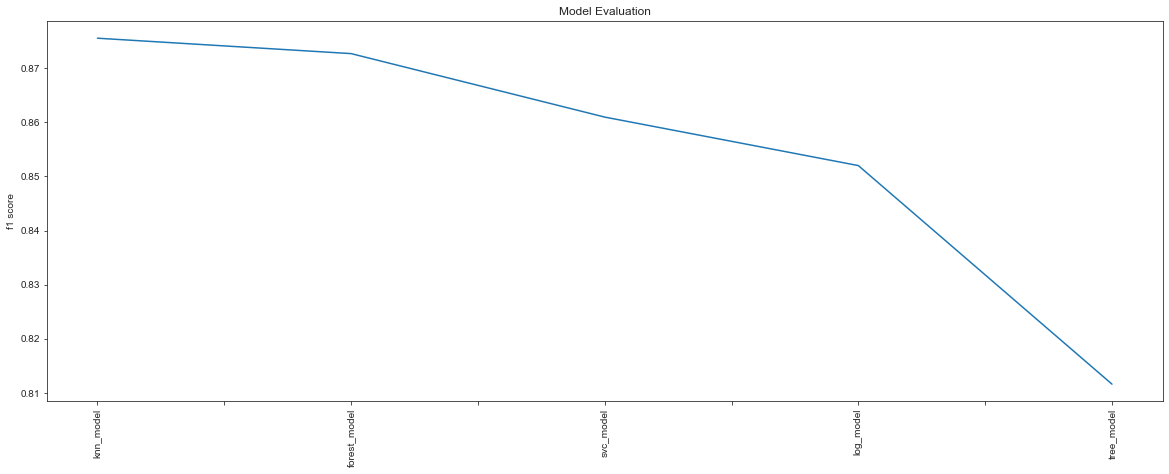

In [22]:
pd.Series(f1_scores).sort_values(ascending=False).plot.line(rot=90,figsize=(20,7))
plt.ylabel('f1 score')
plt.title('Model Evaluation')

Text(0.5, 1.0, 'Model Evaluation')

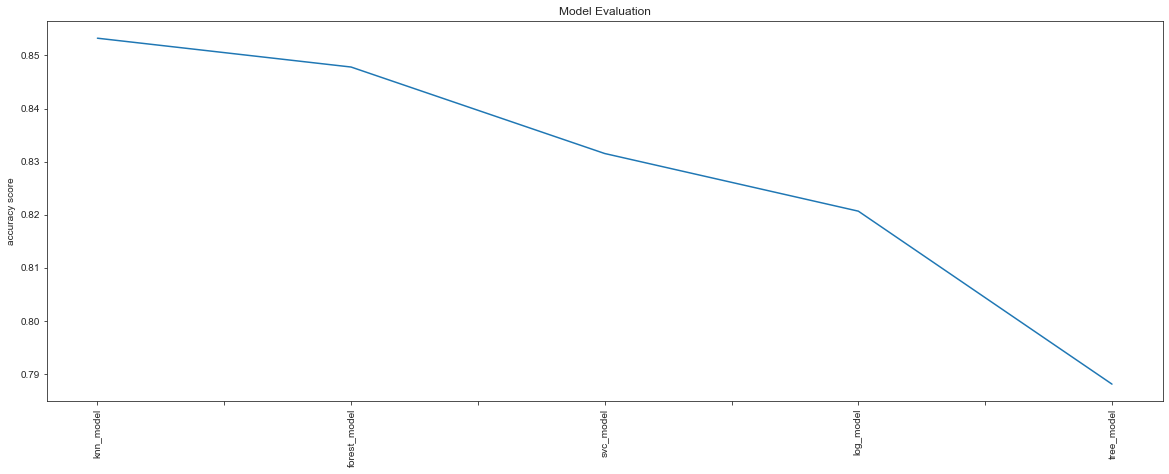

In [21]:
pd.Series(accuracy_scores).sort_values(ascending=False).plot.line(rot=90,figsize=(20,7))
plt.ylabel('accuracy score')
plt.title('Model Evaluation')

The KNN algorithm gives the highest f1 (harmonic mean) and accuracy scores of all the approaches we used. 